# Entrenamiento y evaluación de modelos 

Se entrena y evalúa un modelo de clasificación para identificar inmuebles de alto valor. utilizando varios algoritmos de machine learning. Se comparan modelos basados en árboles (Random Forest, XGBoost) y modelos lineales/distancia (Regresión Logística). Se selecciona el mejor modelo según métricas de rendimiento y se guarda para su uso en producción.

In [13]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings("ignore")

# Configuración de rutas
DATA_PATH = Path("../data/processed/final")


In [14]:
# Carga de datasets procesados
X_train = pd.read_csv(DATA_PATH / "X_train.csv")
X_test = pd.read_csv(DATA_PATH / "X_test.csv")
y_train = pd.read_csv(DATA_PATH / "y_train.csv").values.ravel()
y_test = pd.read_csv(DATA_PATH / "y_test.csv").values.ravel()
print("Datos cargados correctamente.")

Datos cargados correctamente.


In [25]:
imputer = SimpleImputer(strategy='median')
scaler = PowerTransformer()
selector = SelectKBest(score_func=f_classif, k=20)

def build_pipeline(model):
    return Pipeline([
        ('imputer', imputer),
        ('scaler', scaler),
        ('feature_selector', selector),
        ('classifier', model)
    ])

def model_train(model, param_grid, X_train, y_train):
    pipeline = build_pipeline(model)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='recall', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


Entrenando Logistic Regression...


Mejores parámetros para Logistic Regression: {'classifier__C': 10, 'classifier__penalty': 'l2'}
Evaluando Logistic Regression...
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       439
           1       0.98      0.97      0.98       147

    accuracy                           0.99       586
   macro avg       0.99      0.98      0.98       586
weighted avg       0.99      0.99      0.99       586

Confusion Matrix:
 [[436   3]
 [  4 143]]
Accuracy: 0.9881
ROC AUC: 0.9993


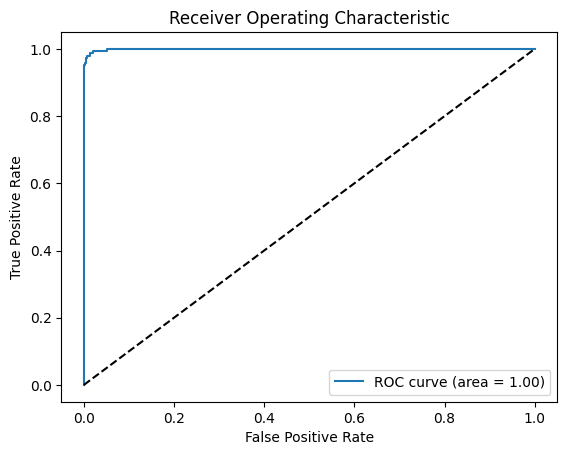

Entrenando Random Forest...
Mejores parámetros para Random Forest: {'classifier__max_depth': 20, 'classifier__n_estimators': 100}
Evaluando Random Forest...
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       439
           1       0.98      0.98      0.98       147

    accuracy                           0.99       586
   macro avg       0.99      0.99      0.99       586
weighted avg       0.99      0.99      0.99       586

Confusion Matrix:
 [[436   3]
 [  3 144]]
Accuracy: 0.9898
ROC AUC: 0.9996


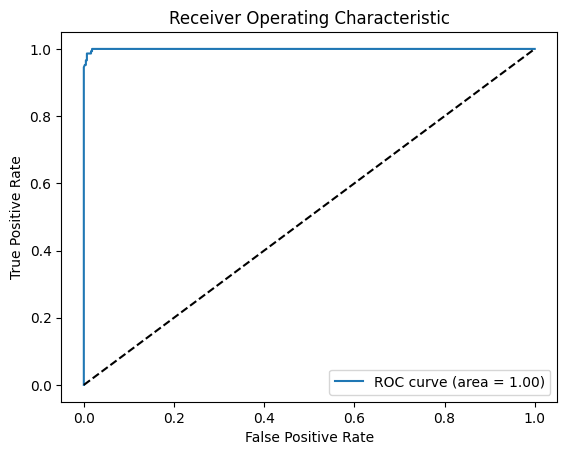

Entrenando XGBoost...
Mejores parámetros para XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Evaluando XGBoost...
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       439
           1       0.97      0.96      0.97       147

    accuracy                           0.98       586
   macro avg       0.98      0.98      0.98       586
weighted avg       0.98      0.98      0.98       586

Confusion Matrix:
 [[435   4]
 [  6 141]]
Accuracy: 0.9829
ROC AUC: 0.9995


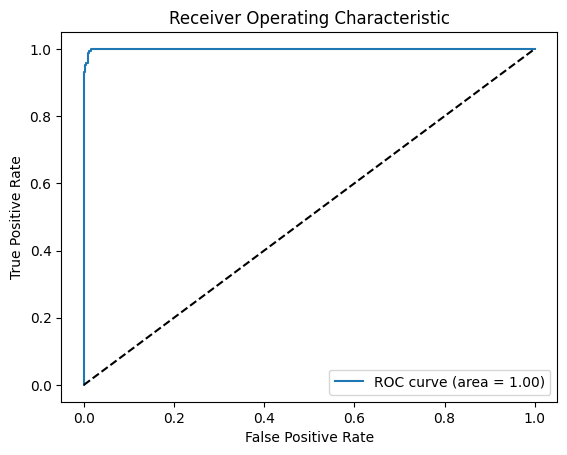

Entrenamiento y evaluación completados.
El mejor modelo es Random Forest con un ROC AUC de 0.9996


In [26]:
# Definición de modelos y parámetros
models_params = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l2']
    }),
    'Random Forest': (RandomForestClassifier(), {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20]
    }),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 6]
    })
}

# Entrenamiento y evaluación de modelos
best_models = {}
for model_name, (model, param_grid) in models_params.items():
    print(f"Entrenando {model_name}...")
    best_model, best_params = model_train(model, param_grid, X_train, y_train)
    print(f"Mejores parámetros para {model_name}: {best_params}")
    print(f"Evaluando {model_name}...")
    evaluate_model(best_model, X_test, y_test)
    best_models[model_name] = best_model
print("Entrenamiento y evaluación completados.")

# Selección del mejor modelo basado en ROC AUC
best_model_name = None
best_roc_auc = 0
for model_name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model_name = model_name
print(f"El mejor modelo es {best_model_name} con un ROC AUC de {best_roc_auc:.4f}")

In [27]:
# Guardar el mejor modelo
import joblib
MODEL_PATH = Path("../models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
best_model = best_models[best_model_name]
filename = f"best_model_{best_model_name.replace(' ', '_').lower()}.joblib"
joblib.dump(best_model, MODEL_PATH / filename)
print(f"Mejor modelo guardado en {MODEL_PATH / filename}")


Mejor modelo guardado en ../models/best_model_random_forest.joblib


Ya que es necesario identificar que propiedades define que un inmueble es de alto valor, se procede a observar la importancia de las variables en los modelos basados en árboles.

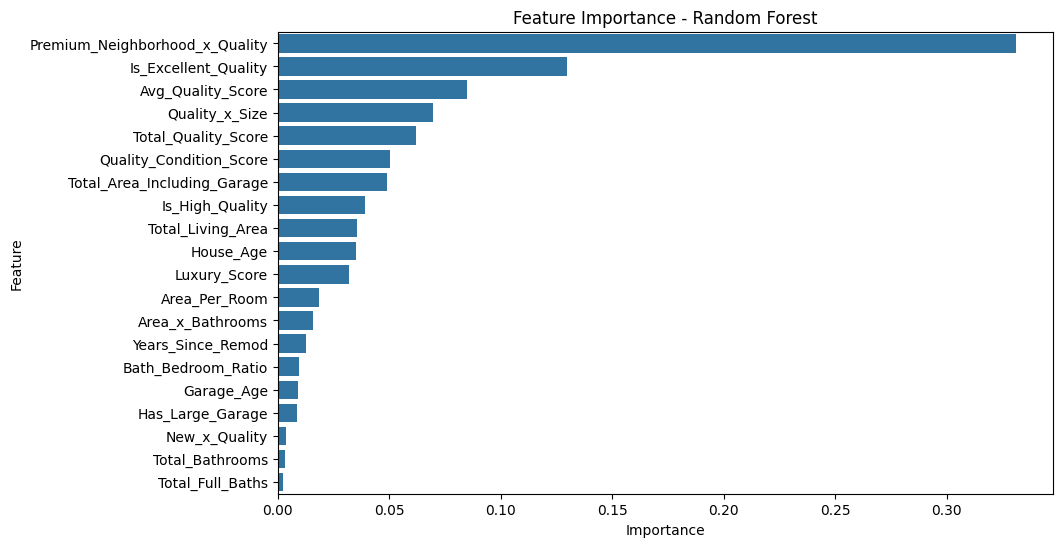

In [29]:
# Análisis de importancia de características:
if best_model_name in ['Random Forest', 'XGBoost']:
    model = best_models[best_model_name].named_steps['classifier']
    feature_indices = best_models[best_model_name].named_steps['feature_selector'].get_support(indices=True)
    feature_names = X_train.columns[feature_indices]
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'Feature Importance - {best_model_name}')
    plt.show()

elif best_model_name == 'Logistic Regression':
    model = best_models[best_model_name].named_steps['classifier']
    feature_indices = best_models[best_model_name].named_steps['feature_selector'].get_support(indices=True)
    feature_names = X_train.columns[feature_indices]
    coefficients = model.coef_[0]
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.title('Feature Coefficients - Logistic Regression')
    plt.show()

Modelos agnósticos como rules de asociación o LIME/SHAP podrían ser considerados en futuras iteraciones para mejorar la interpretabilidad del modelo.